In [1]:
from utils import request_price
from numpy import sqrt
from pandas import DataFrame
from pandas import Series, concat

import matplotlib.pyplot as plt
plt.style.use('dark_background')

from pandas import to_datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
ticker = 'goau4.sa'
start = '2010-06-15'
end = '2020-06-15'

In [3]:
lamb_median_positive = lambda x, t, y: x.rolling(t).mean() + y
lamb_median_negative = lambda x, t, y: x.rolling(t).mean() - y

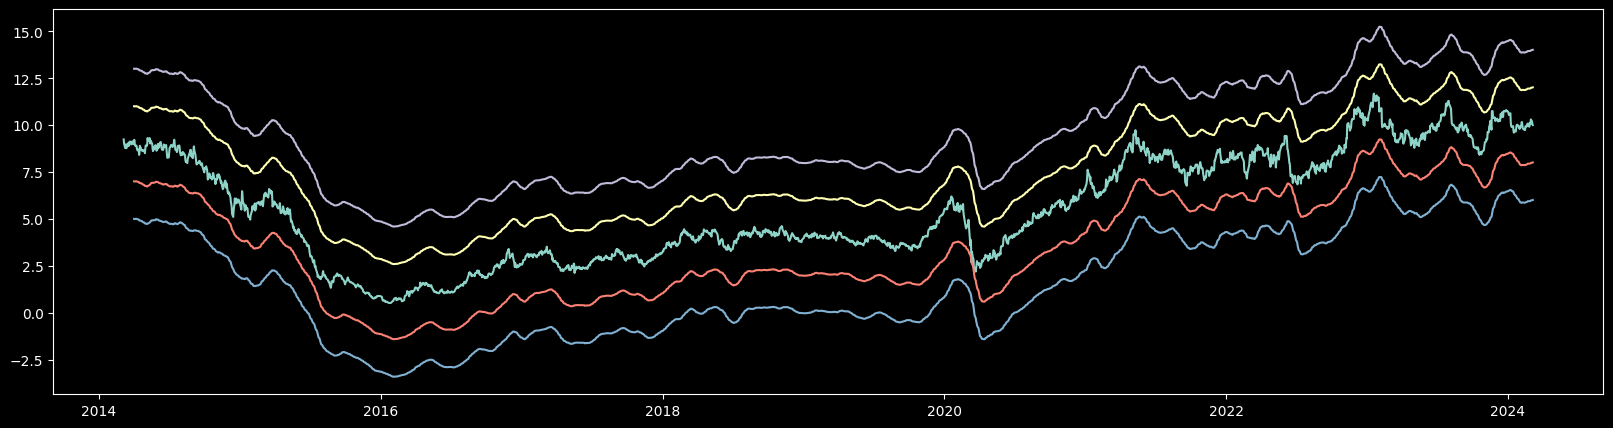

price > +x8,                | 0.0000 | 0  
price < +x8 and price > +x4 | 0.0000 | 0  
price < +x4 and price > -x4 | 0.9920 | 2466  
price < -x4 and price > -x8 | 0.0004 | 1  
price < -x8,                | 0.0000 | 0  


In [4]:
df_price = request_price.get_prices_yf(ticker, period='10y')

# mult = sqrt(df_price.adj_close.std()) / df_price.adj_close.mean()
# print(f'# Multiplicador das bandas: {mult}')

plt.figure(figsize=(20, 5))
plt.plot(df_price)

mm = 20

plt.plot(lamb_median_positive(df_price, mm, 2))
plt.plot(lamb_median_positive(df_price, mm, 4))

plt.plot(lamb_median_negative(df_price, mm, 2))
plt.plot(lamb_median_negative(df_price, mm, 4))
plt.show()


df_price['median_Pos_x4'] = lamb_median_positive(df_price['adj_close'], mm, 2)
df_price['median_Pos_x8'] = lamb_median_positive(df_price['adj_close'], mm, 4)

df_price['median_Neg_x4'] = lamb_median_negative(df_price['adj_close'], mm, 2)
df_price['median_Neg_x8'] = lamb_median_negative(df_price['adj_close'], mm, 4)


cont1 = 0
cont2 = 0
cont3 = 0
cont4 = 0
cont5 = 0

for price, median_Pos_x4, median_Pos_x8, median_Neg_x4, median_Neg_x8 in df_price.values:
    
    if price > median_Pos_x8:
        cont1 += 1

    if price < median_Pos_x8 and price > median_Pos_x4:
        cont2 += 1

    if price < median_Pos_x4 and price > median_Neg_x4:
        cont3 += 1

    if price < median_Neg_x4 and price > median_Neg_x8:
        cont4 += 1

    if price < median_Neg_x8:
        cont5 += 1

print(f'price > +x8,                | {cont1 / len(df_price.adj_close) :.4f} | {cont1}  ')
print(f'price < +x8 and price > +x4 | {cont2 / len(df_price.adj_close) :.4f} | {cont2}  ')
print(f'price < +x4 and price > -x4 | {cont3 / len(df_price.adj_close) :.4f} | {cont3}  ')
print(f'price < -x4 and price > -x8 | {cont4 / len(df_price.adj_close) :.4f} | {cont4}  ')
print(f'price < -x8,                | {cont5 / len(df_price.adj_close) :.4f} | {cont5}  ')
    

In [5]:
df_price = request_price.get_prices_yf('goau4.sa', period='5y')

def bands(df_price):
    _median = 60
    _desloc = 1
    df_price[f'median_{_median}'] = df_price['adj_close'].rolling(_median).median()

    df_price = df_price.dropna()

    band_pos = []
    band_neg = []

    for adj_close, median_60 in df_price.values:
        
        pos = median_60 + sqrt(median_60)
        neg = median_60 - sqrt(median_60)

        band_pos.append(pos)
        band_neg.append(neg)

    df_price['pos'] = band_pos
    df_price['neg'] = band_neg

    df_price['pos'] = df_price['pos'].shift(_desloc)
    df_price['neg'] = df_price['neg'].shift(_desloc)
    return df_price

# b = bands(df_price)
# plt.figure(figsize=(20, 5))
# plt.plot(b.pos)
# plt.plot(b.median_60)
# plt.plot(b.adj_close)
# plt.plot(b.neg)
# plt.show()


In [6]:

from create_synthetic_data import synthetic_data_b

df_price = request_price.get_prices_yf('goau4.sa', period='5y')

start_data = '2024-03-06'
# df_price_start = bands(df_price)

while True:
    df_synthetic_data = synthetic_data_b(df_price[['adj_close']].iloc[-1][0], start_data, 2500)
    _std1 = df_synthetic_data.adj_close.std()
    _std2 = df_price.adj_close.std()
    if _std1 > (_std2-1) and _std1 < (_std2+1):
        break

df_concat = concat([df_price, df_synthetic_data], axis=0)

df_bands = bands(df_concat)

print('# df_price')
print(f'std: {df_price.adj_close.std() :.3f}')
print(f'mean: {df_price.adj_close.mean() :.3f}')
print()
print('# df_synthetic_data')
print(f'std: {df_synthetic_data.adj_close.std() :.3f}')
print(f'mean: {df_synthetic_data.adj_close.mean() :.3f}')

plt.figure(figsize=(20, 5))
plt.plot(df_bands.pos)
plt.plot(df_bands.adj_close)
plt.plot(df_bands.neg)
plt.axvline(to_datetime(start_data), linewidth=0.50, linestyle=':')
plt.show()


TypeError: synthetic_data_b() takes 1 positional argument but 3 were given

In [ ]:
df_price = request_price.get_prices_yf('vale3.sa', period='1y')

def_month = lambda date: str(date).split('-')[1]

def separa_preco_por_mes(df_price):
    df_price = df_price.reset_index()
    serie_price_motch = []
    df_data = DataFrame()

    for i in range(len(df_price)):
        if not(i==0):
            date = df_price['Date'].values
            price = df_price['adj_close'].values
            
            month0 = def_month(date[i-1])
            month1 = def_month(date[i])

            serie_price_motch.append(price[i-1])

            if month1 != month0:
                df_serie_price_motch = DataFrame(serie_price_motch, columns=[month0])
                df_data = concat([df_data, df_serie_price_motch], axis=1)
                serie_price_motch = []

    return df_data

    
df_price_motch = separa_preco_por_mes(df_price)

calc = lambda x: x.mean() - x.std() - x.median()

print(df_price.apply(calc))
print()
df_price_motch.apply(calc).mean()

adj_close   -3.514494
dtype: float64



-2.040623836373563

In [14]:
retorno = df_price.pct_change(1)
test = retorno - retorno.shift(1)
print(test.mean())
print(test.std())

adj_close    0.000005
dtype: float64
adj_close    0.03914
dtype: float64
